# Shape Analysis of Cancer Cells

Lead author: Nina Miolane.

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src="figures/cells_image.png" width=600px />
</center>

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

In [1]:
from decimal import Decimal
import matplotlib.pyplot as plt

import geomstats.backend as gs
import numpy as np
from nsimplices import *
from common import *
import scipy.stats as stats

gs.random.seed(2021)

In [2]:
dataset_name = 'osteosarcoma'
rescale = True

# 2. Dataset Description

We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*, respectively representing a more agressive and a less agressive cancer.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

Each cell comes from a raw image containing a set of cells, which was thresholded to generate binarized images.

<td>
    <img src="figures/binarized_cells.png" width=400px />
</td>

After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [3]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")

Total number of cells : 650


The cells are grouped by treatment class in the dataset : 
- the *control* cells, 
- the cells treated with *Cytd*,
- and the ones treated with *Jasp*. 

Additionally, in each of these classes, there are two cell lines : 
- the *DLM8* cells, and
- the *DUNN* ones.

This is shown by displaying the unique elements in the lists `treatments` and `lines`:

In [4]:
import pandas as pd

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)
METRICS = ['SRV', 'Linear']

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


The size of each class is displayed below:

In [5]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [6]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [7]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 2000

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

(1115.85205078125, 1229.14990234375, -283.7848876953125, -199.1531005859375)

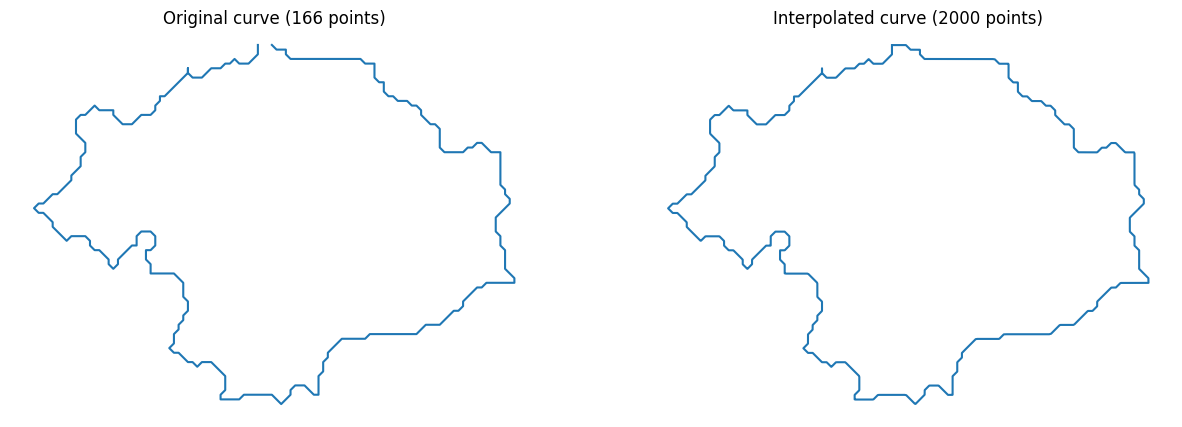

In [8]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

# plt.savefig(os.path.join(figs_dir, "interpolation.svg"))
# plt.savefig(os.path.join(figs_dir, "interpolation.pdf"))

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [9]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (top row shows control, i.e. non-treated cells; bottom rows shows treated cells) across cell lines (left and blue for dlm8 and right and orange for dunn).

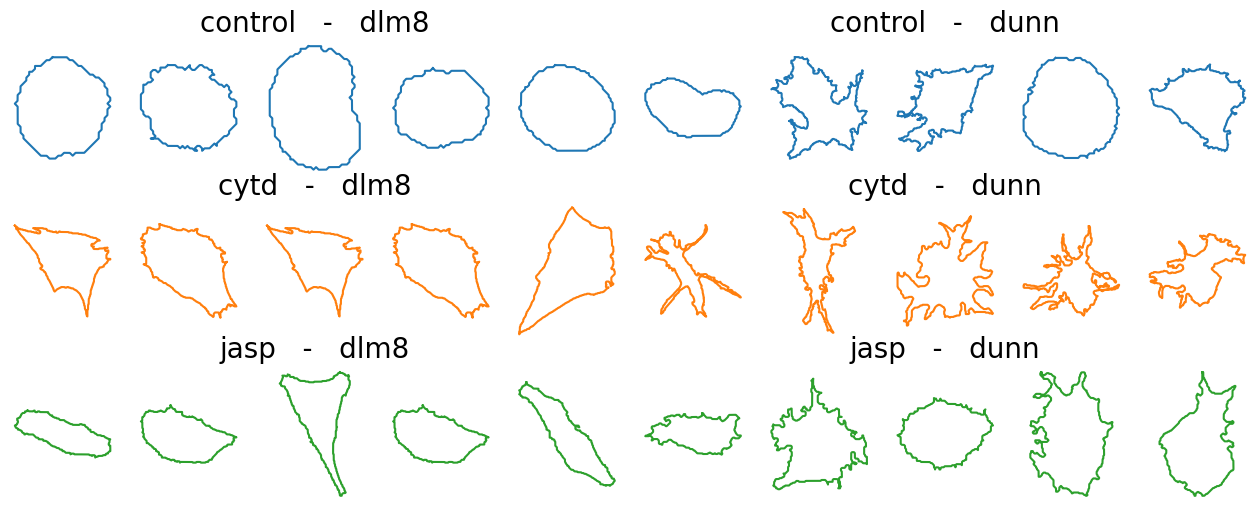

In [10]:
n_cells_to_plot = 5

fig = plt.figure(figsize=(16, 6))
count = 1
for i, treatment in enumerate(TREATMENTS):
    for line in LINES:
        cell_data = ds_interp[treatment][line]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(3, 2 * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color="C" + str(i))
            plt.xlim(-170, 170)
            plt.ylim(-170, 170)
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{treatment}   -   {line}", fontsize=20)
# plt.savefig(os.path.join(figs_dir, "sample_cells.svg"))
# plt.savefig(os.path.join(figs_dir, "sample_cells.pdf"))

In [11]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

In [12]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

### Alignment

In the following alignment function, we first quotient out translation and rescaling. After that, we perform alignment by quotienting out reparameterization.

We did not quotient out rotation due to three reasons:
- The `align` function in `SRVRotationReparametrizationBundle` does not support `DynamicProgrammingAligner`.
- Right now reparameterization causes the loss of important shape characteristics, and we want to focus on this issue.
- The base curve we chose is a unit circle and quotienting out rotation will not significantly affect the result.

Write a function to generate unit circle to serve as the base curve.

In [13]:
def generate_circle(num_points):
    """ 
    Generate num_points points on a circle 
    """

    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    
    x = np.cos(angles)
    y = np.sin(angles)
    
    points = np.column_stack((x, y))
    
    return points

In [14]:
BASE_CURVE = generate_circle(k_sampling_points)

Align cells in the osteosarcoma datast and the `BASE_CURVE`

In [15]:
def align(point, base_point):
    """ 
    Quotienting out translation (projection) and rescaling (normalize)
    Align point with base_point via quotienting out reparameterization
    """
    total_space = DiscreteCurvesStartingAtOrigin(k_sampling_points=k_sampling_points)
    aligner = DynamicProgrammingAligner(total_space)
    total_space.fiber_bundle = SRVReparametrizationBundle(total_space, aligner=aligner)
    
    point = total_space.projection(point)
    base_point = total_space.projection(base_point)
    point = total_space.normalize(point)
    base_point = total_space.normalize(base_point)

    base_point = total_space.projection(base_point)
    point = total_space.projection(point)
    other_aligned = total_space.fiber_bundle.align(point, base_point)
    return other_aligned

Pick a cell from the osteosarcoma dataset and align it with `BASE_CURVE`

In [16]:

# treatment = 'control'
# line = 'dlm8'
# index = 42
treatment = 'jasp'
line = 'dunn'
index = 90
unaligned_cell = ds_proc[treatment][line][index]

In [17]:
aligned_cell = align(unaligned_cell, BASE_CURVE)

calling align in DynamicProgrammingAligner


Visualize `BASE_CURVE`, unaligned cell and aligned cell

Text(0.5, 1.0, 'aligned')

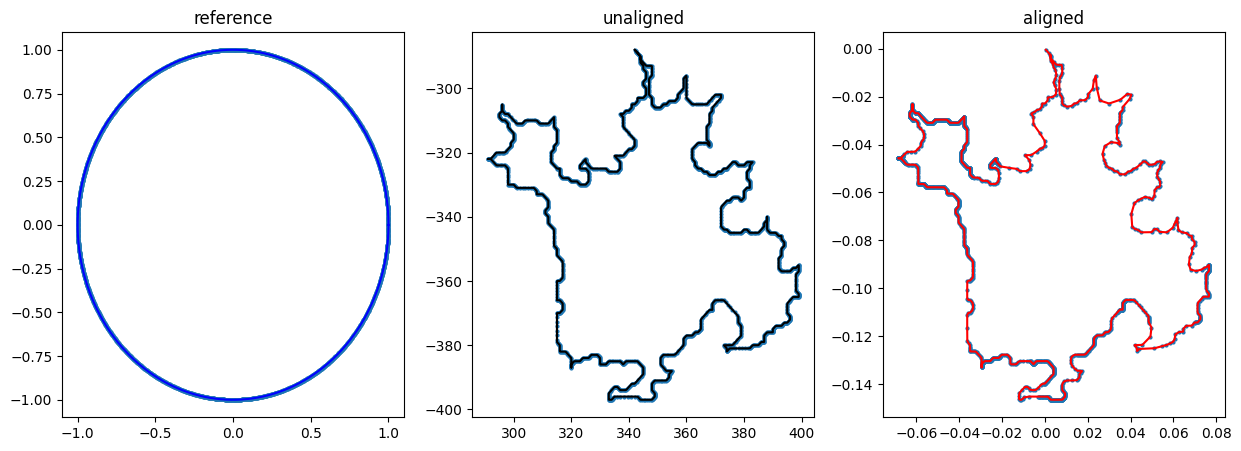

In [18]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
ax = plt.gca()
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1], "blue")
plt.scatter(BASE_CURVE[:, 0], BASE_CURVE[:, 1], s=4)
plt.title('reference')

fig.add_subplot(132)
ax = plt.gca()
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1], "black")
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4)
plt.title('unaligned')


fig.add_subplot(133) 
ax = plt.gca()
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1], "red")
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4)
plt.title("aligned")


Pick another cell and visualize the alignment 

calling align in DynamicProgrammingAligner


Text(0.5, 1.0, 'aligned')

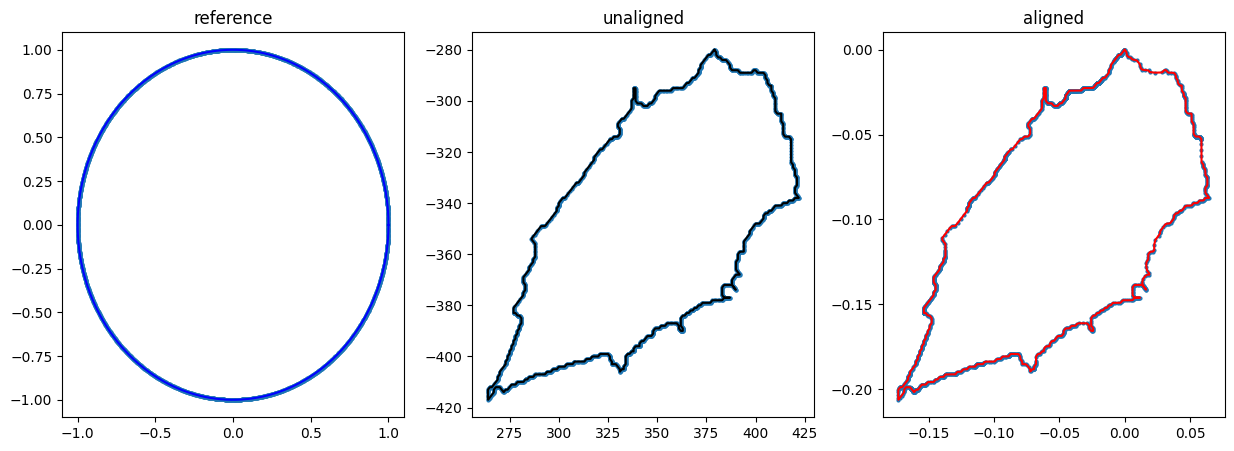

In [19]:
treatment = 'cytd'
line = 'dlm8'
index = 25
unaligned_cell = ds_proc[treatment][line][index]

aligned_cell = align(unaligned_cell, BASE_CURVE)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
ax = plt.gca()
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1], "blue")
plt.scatter(BASE_CURVE[:, 0], BASE_CURVE[:, 1], s=4)
plt.title('reference')

fig.add_subplot(132)
ax = plt.gca()
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1], "black")
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4)
plt.title('unaligned')


fig.add_subplot(133) 
ax = plt.gca()
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1], "red")
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4)
plt.title("aligned")

Pick another cell and visualize the alignment 

calling align in DynamicProgrammingAligner


Text(0.5, 1.0, 'aligned')

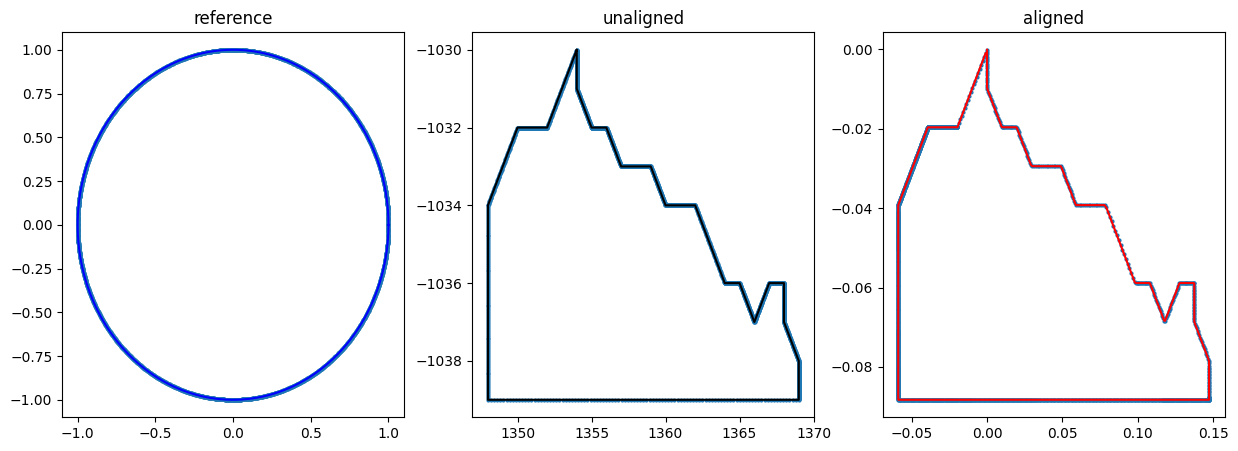

In [20]:
treatment = 'control'
line = 'dlm8'
index = 42
unaligned_cell = ds_proc[treatment][line][index]

aligned_cell = align(unaligned_cell, BASE_CURVE)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
ax = plt.gca()
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1], "blue")
plt.scatter(BASE_CURVE[:, 0], BASE_CURVE[:, 1], s=4)
plt.title('reference')

fig.add_subplot(132)
ax = plt.gca()
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1], "black")
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4)
plt.title('unaligned')


fig.add_subplot(133) 
ax = plt.gca()
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1], "red")
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4)
plt.title("aligned")

Issue 1: After reparameterization, we see the aligned curve lost many important shape characteristics (i.e., overhangs and inviginations on the top right). I think this is caused by inconstant speed for reparameterization. This issue seems to be resolved after increasing the number of sampling points. Need to check with Khanh. 


On the other hand, if we choose the base curve to be a curve in the osteosarcoma dataste

In [21]:
BASE_CURVE = ds_proc['control']['dunn'][0]

 Align the cell with `BASE_CURVE`

In [22]:
aligned_cell = align(unaligned_cell, BASE_CURVE)

calling align in DynamicProgrammingAligner


Visualize `BASE_CURVE`, unaligned cell and aligned cell

Text(0.5, 1.0, 'aligned')

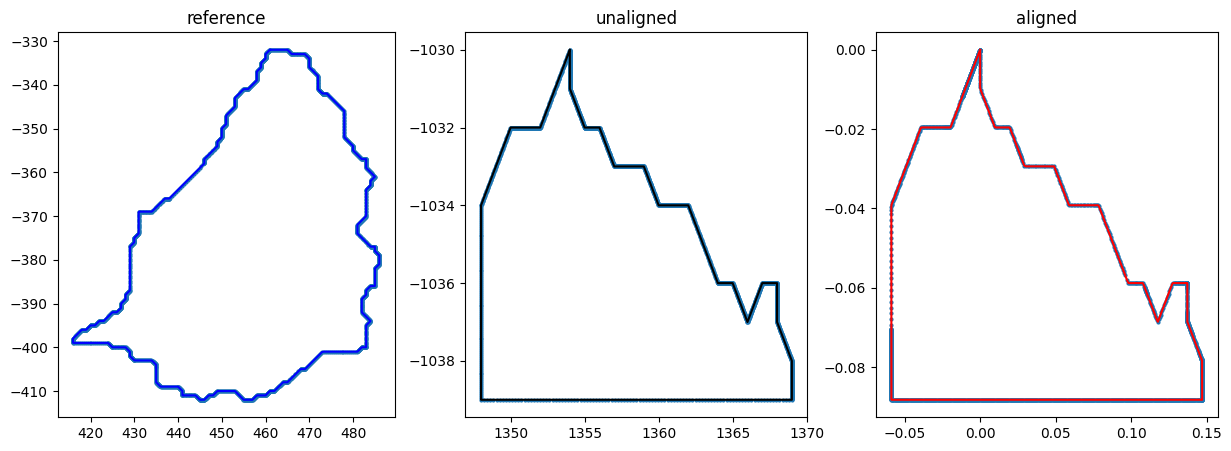

In [23]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
ax = plt.gca()
ax.set_aspect('equal')
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1], "blue")
plt.scatter(BASE_CURVE[:, 0], BASE_CURVE[:, 1], s=4)
plt.title('reference')

fig.add_subplot(132)
ax = plt.gca()
# ax.set_aspect('equal')
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1], "black")
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4)
plt.title('unaligned')


fig.add_subplot(133) 
ax = plt.gca()
# ax.set_aspect('equal')
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1], "red")
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4)
plt.title("aligned")

***
Issue 2: We see that quotienting out rotation would lead to better alignment but the current implementation is not available (`align` function in `SRVReparametrizationBundle` does not support `DynamicProgrammingAligner`). If choosing `BASE_CURVE` using points on a circle suffices, we do not need to consider this case.
***